In [1]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [2]:


import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Layer, Lambda
from sklearn.model_selection import train_test_split
import os
import imageio
import cv2
import glob2
from PIL import Image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import np_utils


Using TensorFlow backend.


In [3]:
import glob

In [4]:
example_image = imageio.imread('example.png')

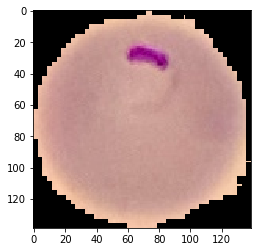

In [5]:
plt.imshow(example_image)

In [6]:
parasitized_cells = os.listdir('C:\\Users\\Thomas\\Malaria Project\\Parasitized\\')
#Importing the data for the parasitized cells

uninfected_cells = os.listdir('C:\\Users\\Thomas\\Malaria Project\\Uninfected')
#importing uninfected cell image data


In [7]:
print(len(parasitized_cells))
print(len(uninfected_cells))
#confirming all the data was put in 

13780
13780


In [8]:
data = []
labels = []

for img in parasitized_cells:
    try:
        img_read = plt.imread('C:\\Users\\Thomas\\Malaria Project\\Parasitized\\' + img)
        img_resize = cv2.resize(img_read, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        print("Error with Parasitized cell")
        
for img in uninfected_cells:
    try: 
        img_read = plt.imread('C:\\Users\\Thomas\\Malaria Project\\Uninfected\\' + img)
        img_resize = cv2.resize(img_read, (50,50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        print("Error with uninfected cell")


Error with Parasitized cell
Error with uninfected cell


### The "errors" in the above cell
Each folder has a .db file in them which cannot be read by imread.  This means that one error per folder is exactly what we are looking for

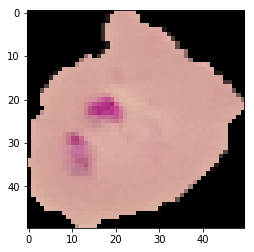

In [9]:
#Checking to see if the images were imported
plt.imshow(data[3])
plt.show()

In [10]:
image_data = np.array(data)
labels = np.array(labels)

In [11]:
#Processing the data for modeling
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [12]:
#Sanity check on labeling
import collections

labels
collections.Counter(labels)

Counter({1: 13779, 0: 13779})

In [13]:
#Train test split 
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = .2, random_state = 42)

In [14]:
y_train = np_utils.to_categorical(y_train, num_classes = 2)

y_test  = np_utils.to_categorical(y_test, num_classes = 2)

In [15]:
print(f"Shape of training image data : {x_train.shape}")
print(f"Shape of testing image data : {x_test.shape}")
print(f"Shape of training labels : {y_train.shape}")
print(f"Shape of testing labels: {y_test.shape}")

Shape of training image data : (22046, 50, 50, 3)
Shape of testing image data : (5512, 50, 50, 3)
Shape of training labels : (22046, 2)
Shape of testing labels: (5512, 2)


In [16]:


import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers



### Model Creation

In [17]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [18]:
height = 50
width = 50
classes = 2
channels = 3
model = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model.summary()








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
____________________

In [19]:
import keras_metrics
import tensorflow as tf

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
keras.backend.get_session().run(tf.global_variables_initializer())

In [22]:
first_model = model.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 18s 806us/step - loss: 0.5594 - acc: 0.7484 - f1_m: 0.7484 - precision_m: 0.7484 - recall_m: 0.7484
Epoch 2/20
22046/22046 [==============================] - 10s 448us/step - loss: 0.2386 - acc: 0.9120 - f1_m: 0.9120 - precision_m: 0.9120 - recall_m: 0.9120
Epoch 3/20
22046/22046 [==============================] - 15s 698us/step - loss: 0.1989 - acc: 0.9318 - f1_m: 0.9318 - precision_m: 0.9318 - recall_m: 0.9318
Epoch 4/20
22046/22046 [==============================] - 86s 4ms/step - loss: 0.1892 - acc: 0.9378 - f1_m: 0.9378 - precision_m: 0.9378 - recall_m: 0.9378
Epoch 5/20
22046/22046 [==============================] - 91s 4ms/step - loss: 0.1823 - acc: 0.9413 - f1_m: 0.9413 - precision_m: 0.9413 - recall_m: 0.9413
Epoch 6/20
22046/22046 [==============================] - 11s 508us/step - loss: 0.1768 - acc: 0.9448 - f1_m: 0.9448 - precision_m: 0.9448 - recall_m: 0.94481s - loss: 0.1777 - acc: 0.9438 - f1_m: 0.9438 - precisio

In [23]:
predictions = model.evaluate(x_test, y_test)


print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

5512/5512 [==============================] - 1s 166us/step
LOSS : 0.11904901193646804
ACCURACY : 0.9644412191582002


In [24]:
y_pred = model.predict(x_test)
#y_pred_tensor = tf.convert_to_tensor(y_pred, np.float32)
#y_test_tensor = tf.convert_to_tensor(y_test, np.float32)
sess = tf.InteractiveSession()



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

y_pred2=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, y_pred2)

array([[2641,   72],
       [ 124, 2675]], dtype=int64)

In [26]:
recall_score(y_test2, y_pred2)

0.9556984637370489

In [27]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred2)))

Recall score of the model: 0.9556984637370489


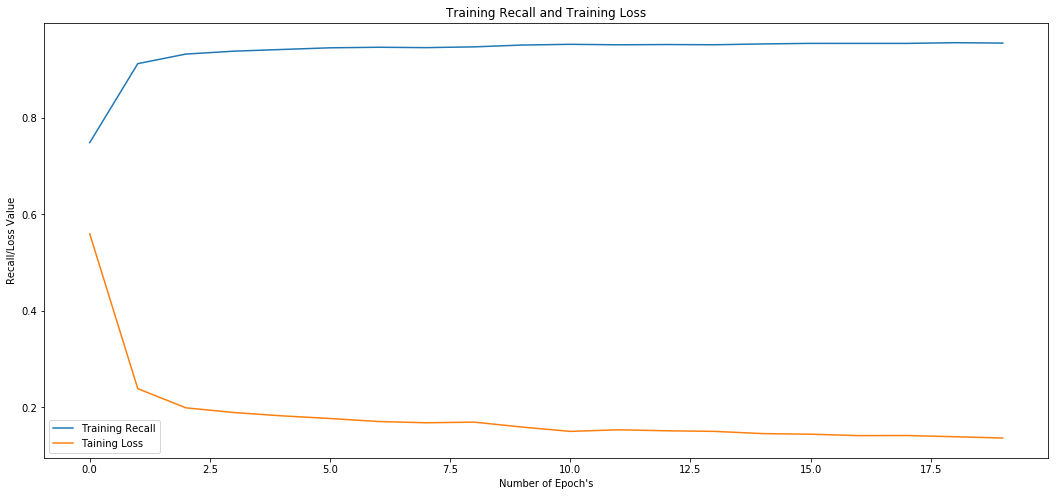

In [28]:
plt.figure(figsize = (18,8))
plt.plot(range(20), first_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), first_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Training Recall and Training Loss')
plt.legend(loc = "best")
#graphing how the accuracy and loss change over the epochs

In [29]:
from keras.preprocessing.image import ImageDataGenerator

In [30]:
train_datagen = ImageDataGenerator(#rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
val_datagen = ImageDataGenerator() #rescale = 1/255.)

train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = True)
val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [31]:
augmented_model = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [32]:

aug_optim = optimizers.Adam(lr = 0.001, decay = 0.001 / 64)
augmented_model.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [33]:
history_augmented_model = augmented_model.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 18s 51ms/step - loss: 0.7382 - acc: 0.6542 - f1_m: 0.6542 - precision_m: 0.6542 - recall_m: 0.6542
Epoch 2/20
344/344 [==============================] - 17s 50ms/step - loss: 0.4096 - acc: 0.8236 - f1_m: 0.8236 - precision_m: 0.8236 - recall_m: 0.8236
Epoch 3/20
344/344 [==============================] - 18s 51ms/step - loss: 0.3392 - acc: 0.8630 - f1_m: 0.8630 - precision_m: 0.8630 - recall_m: 0.8630
Epoch 4/20
344/344 [==============================] - 17s 50ms/step - loss: 0.3170 - acc: 0.8782 - f1_m: 0.8782 - precision_m: 0.8782 - recall_m: 0.8782
Epoch 5/20
344/344 [==============================] - 17s 50ms/step - loss: 0.3021 - acc: 0.8859 - f1_m: 0.8859 - precision_m: 0.8859 - recall_m: 0.8859
Epoch 6/20
344/344 [==============================] - 17s 50ms/step - loss: 0.2957 - acc: 0.8905 - f1_m: 0.8905 - precision_m: 0.8905 - recall_m: 0.8905
Epoch 7/20
344/344 [==============================] - 17s 50ms/step - loss: 0.2875

In [34]:
prediction_2 = augmented_model.evaluate_generator(val_generator, steps = 5)

In [35]:


print(f'LOSS : {prediction_2[0]}')
print(f'ACCURACY : {prediction_2[1]}')

LOSS : 0.13098569810390473
ACCURACY : 0.9625


In [36]:
print(prediction_2)

[0.13098569810390473, 0.9625, 0.9624999403953552, 0.9625, 0.9625]


In [37]:
#y_pred_augmented = augmented_model.predict_generator(val_generator, steps = 5)


config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 31} )
sess = tf.Session(config=config) 
sess.as_default()

y_test_tensor = tf.convert_to_tensor(y_test, np.float32)

y_pred_augmented = augmented_model.predict(x_test)
y_pred_augmented_tensor = tf.convert_to_tensor(y_pred_augmented, np.float32)


In [38]:
from sklearn.metrics import confusion_matrix
y_pred2_augmented=np.argmax(y_pred_augmented, axis=1)
y_test2=np.argmax(y_test, axis=1)
augmented_matrix = confusion_matrix(y_test2, y_pred2_augmented)
print(augmented_matrix)

[[2594  119]
 [ 116 2683]]


In [39]:
recall_score(y_test2, y_pred2_augmented)

0.9585566273669167

### Second model
The second model will look at what happens to our metrics if we remove one of the layers in the CNN.  The model with one less layer will be CNNbuild2.

In [40]:
def CNNbuild2(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [41]:
height = 50
width = 50
classes = 2
channels = 3
model2 = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 11, 11, 32)        128       
__________

In [42]:
model2.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m])

In [43]:
second_model = model2.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 10s 473us/step - loss: 0.5912 - acc: 0.7354 - f1_m: 0.7354 - precision_m: 0.7354 - recall_m: 0.73545
Epoch 2/20
22046/22046 [==============================] - 10s 433us/step - loss: 0.2425 - acc: 0.9098 - f1_m: 0.9098 - precision_m: 0.9098 - recall_m: 0.9098
Epoch 3/20
22046/22046 [==============================] - 10s 449us/step - loss: 0.2062 - acc: 0.9296 - f1_m: 0.9296 - precision_m: 0.9296 - recall_m: 0.9296
Epoch 4/20
22046/22046 [==============================] - 9s 424us/step - loss: 0.1853 - acc: 0.9383 - f1_m: 0.9383 - precision_m: 0.9383 - recall_m: 0.9383
Epoch 5/20
22046/22046 [==============================] - 9s 427us/step - loss: 0.1781 - acc: 0.9423 - f1_m: 0.9423 - precision_m: 0.9423 - recall_m: 0.9423
Epoch 6/20
22046/22046 [==============================] - 9s 421us/step - loss: 0.1728 - acc: 0.9462 - f1_m: 0.9462 - precision_m: 0.9462 - recall_m: 0.9462
Epoch 7/20
22046/22046 [==============================

In [44]:
predictions2 = model2.evaluate(x_test, y_test)


print(f'LOSS : {predictions2[0]}')
print(f'ACCURACY : {predictions2[1]}')

5512/5512 [==============================] - 1s 175us/step
LOSS : 0.13985425622590394
ACCURACY : 0.954100145137881


In [45]:
model2_y_pred = model2.predict(x_test)
model2_y_pred2=np.argmax(model2_y_pred, axis=1)
#y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, model2_y_pred2)

array([[2662,   51],
       [ 202, 2597]], dtype=int64)

In [46]:
print("Recall score of the model: " +str(recall_score(y_test2, model2_y_pred2)))

Recall score of the model: 0.9278313683458378


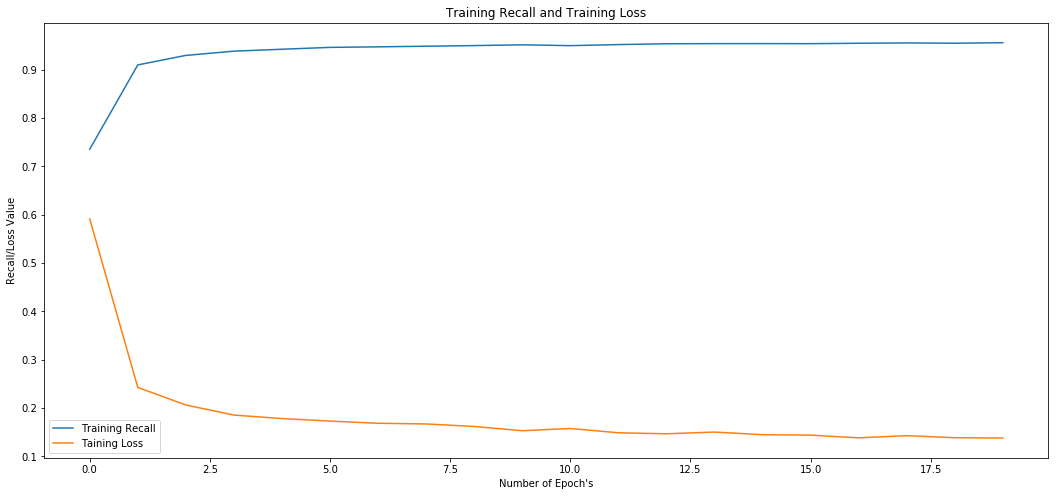

In [47]:
plt.figure(figsize = (18,8))
plt.plot(range(20), second_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), second_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Training Recall and Training Loss')
plt.legend(loc = "best")
#graphing how the accuracy and loss change over the epochs

In [48]:
augmented_model2 = CNNbuild2(height = height, width = width, classes = classes, channels = channels)
augmented_model2.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [49]:
history_augmented_model = augmented_model2.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 17s 50ms/step - loss: 0.7504 - acc: 0.6035 - f1_m: 0.6035 - precision_m: 0.6035 - recall_m: 0.6035 1s - loss: 0.7629 - acc: 0.5980 - f1_m: 0.5980 - precision_m: 0.5980
Epoch 2/20
344/344 [==============================] - 17s 48ms/step - loss: 0.5152 - acc: 0.7456 - f1_m: 0.7456 - precision_m: 0.7456 - recall_m: 0.7456
Epoch 3/20
344/344 [==============================] - 17s 48ms/step - loss: 0.3526 - acc: 0.8529 - f1_m: 0.8529 - precision_m: 0.8529 - recall_m: 0.8529
Epoch 4/20
344/344 [==============================] - 18s 54ms/step - loss: 0.3128 - acc: 0.8767 - f1_m: 0.8767 - precision_m: 0.8767 - recall_m: 0.8767
Epoch 5/20
344/344 [==============================] - 17s 49ms/step - loss: 0.2939 - acc: 0.8864 - f1_m: 0.8864 - precision_m: 0.8864 - recall_m: 0.8864
Epoch 6/20
344/344 [==============================] - 17s 49ms/step - loss: 0.2866 - acc: 0.8933 - f1_m: 0.8933 - precision_m: 0.8933 - recall_m: 0.8933
Epoch 7/20
34

In [50]:
augmented_prediction_2 = augmented_model2.evaluate_generator(val_generator, steps = 5)

In [51]:
y_pred_augmented2 = augmented_model2.predict(x_test)
y_pred_augmented_tensor2 = tf.convert_to_tensor(y_pred_augmented2, np.float32)

y_pred2_augmented=np.argmax(y_pred_augmented2, axis=1)
y_test2=np.argmax(y_test, axis=1)
model2_augmented_matrix = confusion_matrix(y_test2, y_pred2_augmented)
print(model2_augmented_matrix)

[[2640   73]
 [ 162 2637]]


In [52]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred2_augmented)))

Recall score of the model: 0.9421221864951769


## Model 3
For model 3 we are going to use only the accuracy and recall metrics when compiling the model. 

In [53]:
model3 = CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_20 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 11, 11, 32)        128       
__________

In [54]:
#Compiling model 3
model3.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc', recall_m])

In [55]:
third_model = model3.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 12s 566us/step - loss: 0.6210 - acc: 0.7184 - recall_m: 0.7184s - loss: 0.651
Epoch 2/20
22046/22046 [==============================] - 9s 423us/step - loss: 0.2450 - acc: 0.9094 - recall_m: 0.9094
Epoch 3/20
22046/22046 [==============================] - 10s 457us/step - loss: 0.2001 - acc: 0.9297 - recall_m: 0.9297
Epoch 4/20
22046/22046 [==============================] - 10s 447us/step - loss: 0.1836 - acc: 0.9390 - recall_m: 0.9390
Epoch 5/20
22046/22046 [==============================] - 10s 441us/step - loss: 0.1836 - acc: 0.9393 - recall_m: 0.9393
Epoch 6/20
22046/22046 [==============================] - 10s 437us/step - loss: 0.1754 - acc: 0.9428 - recall_m: 0.9428
Epoch 7/20
22046/22046 [==============================] - 10s 437us/step - loss: 0.1709 - acc: 0.9441 - recall_m: 0.9441
Epoch 8/20
22046/22046 [==============================] - 10s 442us/step - loss: 0.1685 - acc: 0.9457 - recall_m: 0.9457
Epoch 9/20
22046/2

In [56]:
predictions3 = model3.evaluate(x_test, y_test)

print(f'LOSS : {predictions3[0]}')
print(f'ACCURACY : {predictions3[1]}')

5512/5512 [==============================] - 1s 157us/step
LOSS : 0.15063721355164345
ACCURACY : 0.9504716981132075


In [57]:
model3_y_pred = model3.predict(x_test)
model3_y_pred2=np.argmax(model3_y_pred, axis=1)
#y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, model3_y_pred2)

array([[2666,   47],
       [ 226, 2573]], dtype=int64)

In [58]:
print("Recall score of the model: " +str(recall_score(y_test2, model3_y_pred2)))

Recall score of the model: 0.9192568774562344


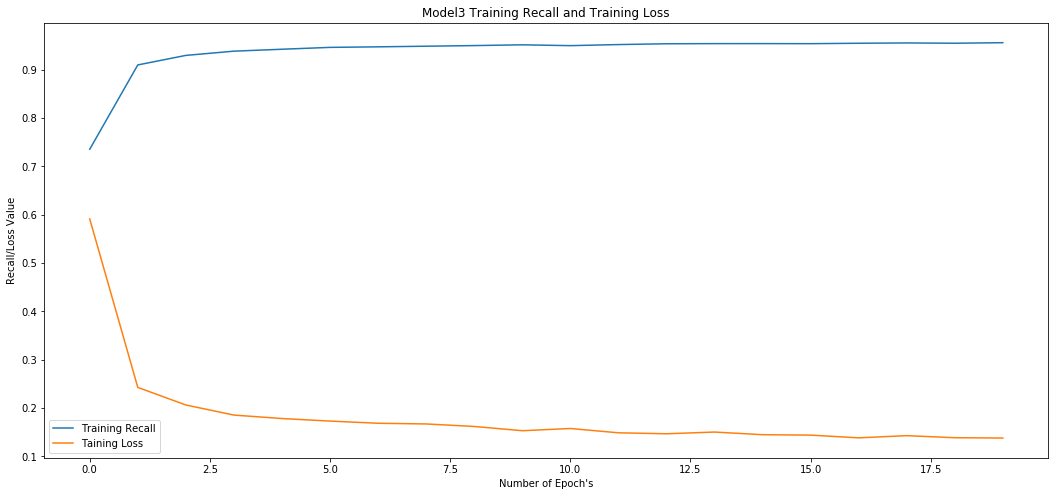

In [59]:
plt.figure(figsize = (18,8))
plt.plot(range(20), second_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), second_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Model3 Training Recall and Training Loss')
plt.legend(loc = "best")

In [60]:
augmented_model3 = CNNbuild(height = height, width = width, classes = classes, channels = channels)

augmented_model3.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc', recall_m])

In [61]:
history_augmented_model3 = augmented_model3.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 16s 46ms/step - loss: 0.7486 - acc: 0.5919 - recall_m: 0.5919
Epoch 2/20
344/344 [==============================] - 15s 45ms/step - loss: 0.6231 - acc: 0.6675 - recall_m: 0.6675
Epoch 3/20
344/344 [==============================] - 15s 45ms/step - loss: 0.4309 - acc: 0.8051 - recall_m: 0.8051
Epoch 4/20
344/344 [==============================] - 16s 46ms/step - loss: 0.3715 - acc: 0.8436 - recall_m: 0.8436
Epoch 5/20
344/344 [==============================] - 16s 47ms/step - loss: 0.3417 - acc: 0.8599 - recall_m: 0.8599
Epoch 6/20
344/344 [==============================] - 16s 46ms/step - loss: 0.3278 - acc: 0.8698 - recall_m: 0.8698
Epoch 7/20
344/344 [==============================] - 16s 48ms/step - loss: 0.3193 - acc: 0.8743 - recall_m: 0.8743
Epoch 8/20
344/344 [==============================] - 16s 46ms/step - loss: 0.3016 - acc: 0.8828 - recall_m: 0.8828
Epoch 9/20
344/344 [==============================] - 17s 51ms/step - lo

In [62]:
y_pred_augmented3 = augmented_model3.predict(x_test)
y_pred_augmented_tensor3 = tf.convert_to_tensor(y_pred_augmented3, np.float32)

y_pred3_augmented=np.argmax(y_pred_augmented3, axis=1)
y_test3=np.argmax(y_test, axis=1)
model3_augmented_matrix = confusion_matrix(y_test2, y_pred3_augmented)
print(model3_augmented_matrix)

[[2606  107]
 [ 119 2680]]


In [63]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred3_augmented)))

Recall score of the model: 0.9574848160057163


### Model 4:  Rescaled augmented images
This model will focus on what happens if we try image rescaling.

For this one we are going to skip the non-augmented version and jump staight into the augmented network. 

In [64]:
rescaled_train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.3,
                                  rotation_range = 30)
rescaled_val_datagen = ImageDataGenerator(rescale = 1/255.)

rescaled_train_generator = train_datagen.flow(x_train, y_train, batch_size = 64, shuffle = True)
#val_generator = val_datagen.flow(x_test, y_test, batch_size = 64, shuffle = False)

In [65]:
rescaled_augmented_model = CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [66]:
rescaled_augmented_model.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [67]:
rescaled_history_augmented_model = rescaled_augmented_model.fit_generator(rescaled_train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 19s 54ms/step - loss: 0.6951 - acc: 0.6538 - f1_m: 0.6538 - precision_m: 0.6538 - recall_m: 0.6538
Epoch 2/20
344/344 [==============================] - 45s 131ms/step - loss: 0.4280 - acc: 0.8102 - f1_m: 0.8102 - precision_m: 0.8102 - recall_m: 0.8102
Epoch 3/20
344/344 [==============================] - 112s 325ms/step - loss: 0.3657 - acc: 0.8522 - f1_m: 0.8522 - precision_m: 0.8522 - recall_m: 0.8522
Epoch 4/20
344/344 [==============================] - 18s 51ms/step - loss: 0.3286 - acc: 0.8712 - f1_m: 0.8712 - precision_m: 0.8712 - recall_m: 0.8712
Epoch 5/20
344/344 [==============================] - 18s 52ms/step - loss: 0.3194 - acc: 0.8787 - f1_m: 0.8787 - precision_m: 0.8787 - recall_m: 0.8787
Epoch 6/20
344/344 [==============================] - 18s 53ms/step - loss: 0.3033 - acc: 0.8865 - f1_m: 0.8865 - precision_m: 0.8865 - recall_m: 0.8865 2s - loss: 0.3051 - acc: 0.8864 - f1_m: 0.8864 - p
Epoch 7/20
344/344 [========

In [68]:
rescaled_prediction = rescaled_augmented_model.evaluate_generator(val_generator, steps = 5)

In [69]:
print(f'LOSS : {rescaled_prediction[0]}')
print(f'ACCURACY : {rescaled_prediction[1]}')

LOSS : 0.1769263491034508
ACCURACY : 0.946875


In [70]:
rescaled_y_pred_augmented = rescaled_augmented_model.predict(x_test)
rescaled_y_pred_augmented_tensor = tf.convert_to_tensor(rescaled_y_pred_augmented, np.float32)

rescaled_y_pred_augmented=np.argmax(rescaled_y_pred_augmented, axis=1)
#y_test2=np.argmax(y_test, axis=1)
rescaled_augmented_matrix = confusion_matrix(y_test2, rescaled_y_pred_augmented)
print(rescaled_augmented_matrix)


[[2612  101]
 [ 127 2672]]


In [71]:
print("Recall score of the model: " +str(recall_score(y_test2, rescaled_y_pred_augmented)))

Recall score of the model: 0.9546266523758485


### Model 5: Sigmoid activation function
For this we are going to use a sigmoid function instead of relu. 

In [72]:
def Sigmoid_CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'sigmoid', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'sigmoid'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'sigmoid'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(32, (3,3), activation = 'sigmoid'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(512, activation = 'sigmoid'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [73]:
model5 = Sigmoid_CNNbuild(height = height, width = width, classes = classes, 
                channels = channels)
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_35 (Dropout)         (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 11, 11, 32)        128       
__________

In [74]:

model5.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['acc',f1_m,precision_m, recall_m])

In [75]:
fifth_model = model5.fit(x_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
22046/22046 [==============================] - 13s 578us/step - loss: 0.6588 - acc: 0.6887 - f1_m: 0.6887 - precision_m: 0.6887 - recall_m: 0.68874s - loss: 0.7203 - acc: 0.6605 -  - ETA: 0s - loss: 0.6619 - acc: 0.6875 - f1_m: 0.6875 - precision_m: 0.6875 - recall_m: 0
Epoch 2/20
22046/22046 [==============================] - 12s 539us/step - loss: 0.4058 - acc: 0.8222 - f1_m: 0.8222 - precision_m: 0.8222 - recall_m: 0.82224s - loss: 0.4
Epoch 3/20
22046/22046 [==============================] - 11s 508us/step - loss: 0.2733 - acc: 0.8957 - f1_m: 0.8957 - precision_m: 0.8957 - recall_m: 0.89572s - loss: 0.2883 - acc: 0.8888 - f1_m: 0.8888 
Epoch 4/20
22046/22046 [==============================] - 11s 497us/step - loss: 0.2144 - acc: 0.9238 - f1_m: 0.9238 - precision_m: 0.9238 - recall_m: 0.9238
Epoch 5/20
22046/22046 [==============================] - 12s 532us/step - loss: 0.1915 - acc: 0.9359 - f1_m: 0.9359 - precision_m: 0.9359 - recall_m: 0.9359
Epoch 6/20
22046/22046 [=

In [76]:
predictions5 = model5.evaluate(x_test, y_test)

print(f'LOSS : {predictions5[0]}')
print(f'ACCURACY : {predictions5[1]}')

5512/5512 [==============================] - 1s 233us/step
LOSS : 0.12445751687373928
ACCURACY : 0.9597242380261248


In [77]:
model5_y_pred = model5.predict(x_test)
model5_y_pred2=np.argmax(model5_y_pred, axis=1)
#y_test2=np.argmax(y_test, axis=1)
confusion_matrix(y_test2, model5_y_pred2)

array([[2667,   46],
       [ 176, 2623]], dtype=int64)

In [78]:
print("Recall score of the model: " +str(recall_score(y_test2, model5_y_pred2)))

Recall score of the model: 0.9371204001429082


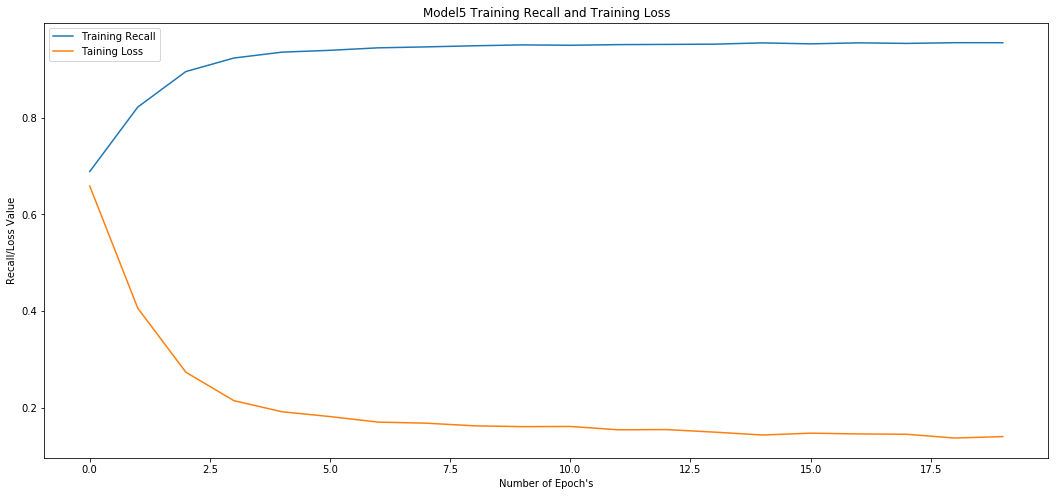

In [79]:
plt.figure(figsize = (18,8))
plt.plot(range(20), fifth_model.history['acc'], label = 'Training Recall')
plt.plot(range(20), fifth_model.history['loss'], label = 'Taining Loss')

plt.xlabel("Number of Epoch's")
plt.ylabel('Recall/Loss Value')
plt.title('Model5 Training Recall and Training Loss')
plt.legend(loc = "best")

In [80]:
augmented_model5 = Sigmoid_CNNbuild(height = height, width = width, classes = classes, channels = channels)

In [81]:
augmented_model5.compile(loss = 'categorical_crossentropy', 
                        optimizer = aug_optim, 
                        metrics = ['acc',f1_m,precision_m, recall_m])

In [82]:
history_augmented_model5 = augmented_model5.fit_generator(train_generator,
                                 steps_per_epoch = len(x_train) // 64,
                                epochs = 20)

Epoch 1/20
344/344 [==============================] - 18s 51ms/step - loss: 0.6920 - acc: 0.6533 - f1_m: 0.6533 - precision_m: 0.6533 - recall_m: 0.6533 6s - loss: 0.7510 - acc: 0.6244 - f1_m: 0.6244 -  - ETA: 3s - loss: 0.7233 - acc: 0.6365 - f1_m: 0.6365
Epoch 2/20
344/344 [==============================] - 17s 50ms/step - loss: 0.5206 - acc: 0.7520 - f1_m: 0.7520 - precision_m: 0.7520 - recall_m: 0.7520
Epoch 3/20
344/344 [==============================] - 18s 51ms/step - loss: 0.4597 - acc: 0.7945 - f1_m: 0.7945 - precision_m: 0.7945 - recall_m: 0.7945
Epoch 4/20
344/344 [==============================] - 16s 46ms/step - loss: 0.4161 - acc: 0.8214 - f1_m: 0.8214 - precision_m: 0.8214 - recall_m: 0.8214 2s - loss: 0.4205 - acc: 0.8193 - f1_m: 0.8193 - precision_m: 0.8
Epoch 5/20
344/344 [==============================] - 15s 44ms/step - loss: 0.3732 - acc: 0.8483 - f1_m: 0.8483 - precision_m: 0.8483 - recall_m: 0.8483
Epoch 6/20
344/344 [==============================] - 16s 47ms/st

In [83]:
prediction_5 = augmented_model5.evaluate_generator(val_generator, steps = 5)

In [84]:
print(f'LOSS : {prediction_5[0]}')
print(f'ACCURACY : {prediction_5[1]}')

LOSS : 0.17599183768033982
ACCURACY : 0.93125


In [85]:
y_pred_augmented5 = augmented_model5.predict(x_test)
y_pred_augmented5_tensor = tf.convert_to_tensor(y_pred_augmented5, np.float32)


In [86]:
y_pred5_augmented=np.argmax(y_pred_augmented5, axis=1)
#y_test2=np.argmax(y_test, axis=1)
augmented_matrix5 = confusion_matrix(y_test2, y_pred5_augmented)
print(augmented_matrix5)

[[2631   82]
 [ 141 2658]]


In [87]:
print("Recall score of the model: " +str(recall_score(y_test2, y_pred5_augmented)))

Recall score of the model: 0.9496248660235799


### Conclusion
    The model with the best recall score is the first model(with augmentation) with a recall of approximately 95.856%.  The expectations are that a convolutional neural network with a relu activation function and max pooling is going to achieve the best results.  For this project those expectations were met.   
    
    Convolutional neural networks are now considered the best choice for computer vision projects and the creation of the convolutional neural network is sometimes credited for the recent explosion of computer vision projects.    (  https://youtu.be/JiN9p5vWHDY  )